In [1]:
import os
import sys
sys.path.append(os.path.abspath('/home/not-naive-bayes-MIL'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import json

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import isde
from dataset import load_metaflow_myeloma_data

sns.set_style('whitegrid')
%matplotlib inline

### Load data

In [2]:
parquet_path = '/mnt/metaflow_myeloma/'
X, Y, Z = load_metaflow_myeloma_data(parquet_path)

INFO:root:Selected patients : [12 13 14 15 16 17 18 23 25 27 28 29 31 33 34 35 37 38 39 40 42 43 45 48
 49 51 52]
INFO:root:Loading patient 12
INFO:root:Loading patient 13
INFO:root:Loading patient 14
INFO:root:Loading patient 15
INFO:root:Loading patient 16
INFO:root:Loading patient 17
INFO:root:Loading patient 18
INFO:root:Loading patient 23
INFO:root:Loading patient 25
INFO:root:Loading patient 27
INFO:root:Loading patient 28
INFO:root:Loading patient 29
INFO:root:Loading patient 31
INFO:root:Loading patient 33
INFO:root:Loading patient 34
INFO:root:Loading patient 35
INFO:root:Loading patient 37
INFO:root:Loading patient 38
INFO:root:Loading patient 39
INFO:root:Loading patient 40
INFO:root:Loading patient 42
INFO:root:Loading patient 43
INFO:root:Loading patient 45
INFO:root:Loading patient 48
INFO:root:Loading patient 49
INFO:root:Loading patient 51
INFO:root:Loading patient 52


In [4]:
p_ids = np.array([11, 12, 13, 14, 15, 16, 17, 18, 23, 24, 25, 27, 28, 29, 31, 33, 34, 35, 37, 38, 39, 40, 42, 43,
 45, 46, 48, 49, 51, 52, 53], dtype=int)

### ISDE

In [5]:
p_id = 12
X_i = X[np.flatnonzero(p_ids==p_id)[0]]
Z_i = Z[np.flatnonzero(p_ids==p_id)[0]]

m=3000
n=2000
max_size=8
min_size=1
n_parts=10
rs=42
hs=np.logspace(-3, 0, 300)
bs=1000

In [6]:
len(X_i)

10000

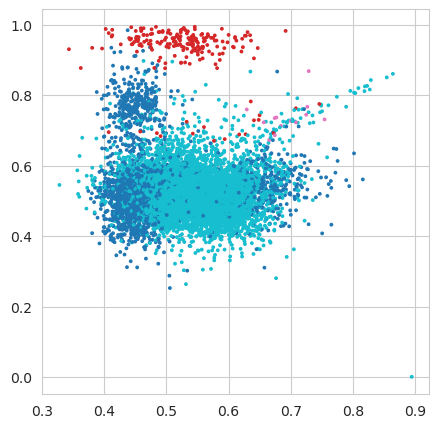

In [7]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

plt.scatter(X_i[:,3], X_i[:,4], s=3, c=Z_i, cmap='tab10')

In [8]:
params = {'hs':hs, 'batch_size':bs}
isde_estimator = isde.ISDE(
    grid_size=n,
    eval_size=m,
    max_block_size=max_size,
    min_block_size=min_size,
    n_partitions=n_parts,
    random_state=rs,
    **params
)
isde_estimator = isde_estimator.fit(X_i, Z_i)

INFO:root:Compute scores by subsets


Computing estimators for subsets of size 1...


/home/not-naive-bayes-MIL/isde.py:195: RuntimeWarning: divide by zero encountered in log
  ll = np.ma.masked_invalid(np.log(a) - np.log(n * (h**d) * np.power(2 * np.pi, d / 2)))


Computing estimators for subsets of size 2...
Computing estimators for subsets of size 3...
Computing estimators for subsets of size 4...
Computing estimators for subsets of size 5...
Computing estimators for subsets of size 6...
Computing estimators for subsets of size 7...
Computing estimators for subsets of size 8...


INFO:root:Compute best partitions


In [9]:
isde_estimator.best_partitions_

[[[0, 1, 2, 3, 4, 5, 6], [7]],
 [[0, 1, 2, 3, 4, 5, 6, 7]],
 [[0, 1, 2, 3, 5, 6], [4, 7]],
 [[0, 1, 2, 3, 5, 6], [4], [7]],
 [[0, 7], [1, 2, 3, 4, 5, 6]],
 [[0], [1, 2, 3, 4, 5, 6], [7]],
 [[0, 1, 2, 3, 4, 5], [6, 7]],
 [[0, 1, 2, 3, 5, 6, 7], [4]],
 [[0, 1, 2, 4, 5, 6], [3, 7]],
 [[0, 1, 2, 4, 5, 6], [3], [7]]]

In [69]:
_, X_i_valid = train_test_split(X_i, test_size=2000, random_state=17, stratify=Z_i)
log_densities = isde_estimator.score(X_i_valid)

partitions = {}
for j, part in enumerate(isde_estimator.best_partitions_):
    partitions[str(part)] = float(log_densities[:,j].sum())

folder = '/home/not-naive-bayes-MIL/myeloma_partitions'
filename = f"partitions_{p_id}.json"
with open(folder+"/"+filename, 'w') as f:
    json.dump(partitions, f)